In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from torchvision.utils import save_image
from tqdm import tqdm
from torchvision.models import vgg19

In [2]:
class DiscriminatorBlock(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int=4,
            stride: int= 2
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                bias=False,
                padding_mode='reflect'
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(
            self,
            in_channels: int=3,
            kernel_size: int=4,
            stride: int=2,
            padding: int=1
    ):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels*2,
                out_channels = 64,
                kernel_size = kernel_size,
                stride = stride,
                padding = padding,
                padding_mode = 'reflect'
            )
        )
        self.conv1 = DiscriminatorBlock(64, 128, kernel_size, 2)
        self.conv2 = DiscriminatorBlock(128, 256, kernel_size, 2)
        self.conv3 = DiscriminatorBlock(256, 512, kernel_size, 1)
        self.final = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=kernel_size, stride=1,
                               padding=1, padding_mode='reflect')

        self.model = nn.Sequential(
            self.initial, self.conv1, self.conv2, self.conv3, self.final
        )

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        return self.model(x)

In [4]:
def test_discriminator():
    a = Discriminator()
    img = torch.ones(10, 3, 256, 256)
    with torch.no_grad():
        print(a.forward(img, img).shape)

In [5]:
test_discriminator()

torch.Size([10, 1, 26, 26])


In [6]:
class GeneratorBlockDown(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int
    ):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect',
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

In [7]:
class GeneratorBlockUp(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            dropout: bool
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5) if dropout else nn.Identity()
        )
    def forward(self, x):
        return self.block(x)

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels: int=3, features: int=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect'
            ),
            nn.LeakyReLU(0.2)
        )
        self.down1 = GeneratorBlockDown(in_channels=features, out_channels=features*2)
        self.down2 = GeneratorBlockDown(in_channels=features*2, out_channels=features*4)
        self.down3 = GeneratorBlockDown(in_channels=features*4, out_channels=features*8)
        self.down4 = GeneratorBlockDown(in_channels=features*8, out_channels=features*8)
        self.down5 = GeneratorBlockDown(in_channels=features*8, out_channels=features*8)
        self.down6 = GeneratorBlockDown(in_channels=features*8, out_channels=features*8)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=features*8,
                      out_channels=features*8,
                      kernel_size=(4,4),
                      stride=(2,2),
                      padding=(1,1),
                      padding_mode="reflect"),
            nn.ReLU()
        )

        self.up1 = GeneratorBlockUp(in_channels=features*8, out_channels=features*8, dropout=True)
        self.up2 = GeneratorBlockUp(in_channels=features*8*2, out_channels=features*8, dropout=True)
        self.up3 = GeneratorBlockUp(in_channels=features*8*2, out_channels=features*8, dropout=True)
        self.up4 = GeneratorBlockUp(in_channels=features*8*2, out_channels=features*8, dropout=False)
        self.up5 = GeneratorBlockUp(in_channels=features*8*2, out_channels=features*4, dropout=False)
        self.up6 = GeneratorBlockUp(in_channels=features*4*2, out_channels=features*2, dropout=False)
        self.up7 = GeneratorBlockUp(in_channels=features*4, out_channels=features, dropout=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=features*2,
                out_channels=in_channels,
                kernel_size=(4,4),
                stride=(2,2),
                padding=(1,1)
            ),
            nn.Tanh()
        )
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        # print(d7.shape, up1.shape)
        up2 = self.up2(torch.cat([d7, up1], dim=1))
        up3 = self.up3(torch.cat([d6, up2], dim=1))
        up4 = self.up4(torch.cat([d5, up3], dim=1))
        up5 = self.up5(torch.cat([d4, up4], dim=1))
        up6 = self.up6(torch.cat([d3, up5], dim=1))
        up7 = self.up7(torch.cat([d2, up6], dim=1))
        return self.final_up(torch.cat([d1, up7], dim=1))

In [9]:
def test_generator():
    test_imgs = torch.ones(10, 3, 256, 256)
    gen = Generator(3, 64)
    print(gen(test_imgs).shape)

In [10]:
test_generator()

torch.Size([10, 3, 256, 256])


In [11]:
class MyDataset(Dataset):
    def __init__(
            self,
            folder_path,
            size : int= 256,
            train : bool = True
    ):
        super().__init__()
        image_names = os.listdir(path=folder_path)
        self.image_paths = [os.path.join(folder_path, x) for x in image_names]
        self.size = size

        self.initial_transform = A.Compose(
            [
                A.Resize(self.size, self.size),
                A.HorizontalFlip(p=0.5) if train else None
            ]
        )

        self.final_transform = A.Compose(
            [
                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ToTensorV2()
            ]
        )



    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.initial_transform(image=image)['image']

        bad_image = np.array(Image.fromarray(image).quantize(8).convert("RGB"))

        image = self.final_transform(image=image)['image']
        bad_image = self.final_transform(image=bad_image)['image']

        return image, bad_image

In [12]:
td = MyDataset('pr_dataset/train')

In [13]:
class VGGLoss:
    def __init__(self):
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse = nn.MSELoss()

    def forward(self, x, y):
        real_f = self.vgg(x)
        gen_f = self.vgg(y)
        return self.mse(real_f, gen_f)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
def save_example(generator, img_path='pr_dataset/val/cat.4003.jpg', res_name=''):


    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    Image.fromarray(image).resize((256, 256)).quantize(8).convert("RGB").save(f'examples_bad/{res_name+"_"}bad.jpg')
    Image.fromarray(image).resize((256, 256)).convert("RGB").save(f'examples_orig/{res_name+"_"}orig.jpg')
    bad_image = np.array(Image.fromarray(image).resize((256, 256)).quantize(8).convert("RGB"))

    # return bad_image

    final_transform = A.Compose(
            [

                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ToTensorV2()
            ]
        )

    q = 1
    while 2**q<max(image.shape[:2]):
        q+=1

    shabl = np.ones((int(2**q), int(2**q), 3))
    shabl[:bad_image.shape[0], :bad_image.shape[1], :] = bad_image


    with torch.no_grad():
        in_img = final_transform(image=shabl)['image'].unsqueeze(0)
        image_nn = generator(in_img.to(device)).detach().cpu()[:, :, :bad_image.shape[0], :bad_image.shape[1]]

    # print(ttt.shape)
    save_image(((image_nn*0.5)+0.5).abs(), f'examples_nn/{res_name+"_"}nn.jpg')

In [16]:
generator = Generator().to(device)

In [17]:
save_example(generator)

In [18]:
def save_model_checkpoint(model, optimizer, epoch, filename):
    print('saving checkpoint')

    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, filename+f'_{epoch}.pth')

In [19]:
def load_checkpoint(model, optimizer, lr, file):

    global curr_epoch
    print('load checkpoint')
    checkpoint = torch.load(file, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    curr_epoch = checkpoint['epoch']
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [20]:
batch_size = 8

In [21]:
train_dataset = MyDataset(folder_path='pr_dataset/train', train=True)
test_dataset = MyDataset(folder_path='pr_dataset/val', train=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Обучим ган без vgg19

In [22]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [23]:
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [24]:
preload = False
curr_epoch = 0
if preload:
        load_checkpoint(generator, gen_optimizer, 2e-4, 'save_models/pix2pix_gen_10.pth')
        load_checkpoint(discriminator, disc_optimizer, 2e-4, 'save_models/pix2pix_disc_10.pth')
curr_epoch=0

In [25]:
generator.eval()
discriminator.eval()
save_example(generator)

In [27]:
num_epochs=200
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()
vgg_loss = VGGLoss()
l1_loss = nn.L1Loss()

In [46]:
for epoch in range(curr_epoch+1, num_epochs):
    print(f'epoch_{epoch}')
    discriminator.train(True)
    generator.train(True)
    train_loss = 0
    test_loss = 0

    for image, bad_image in tqdm(train_dataloader, leave=True):
        ### Train discriminator
        image_fake = generator(bad_image.to(device))
        disc_fake = discriminator(image_fake.detach(), bad_image.to(device))
        disc_real = discriminator(image.to(device), bad_image.to(device))

        discriminator_loss = 0.5 * (bce(disc_real, torch.ones_like(disc_real)).to(device) +\
                             bce(disc_fake, torch.zeros_like(disc_fake).to(device)))
        discriminator.zero_grad()
        discriminator_loss.backward()
        disc_optimizer.step()


        ### Train Generator
        disc_fake = discriminator(image_fake, bad_image.to(device))
        mse_loss = mse(image_fake, image.to(device))
        adversarial_loss = bce(disc_fake, torch.ones_like(disc_fake).to(device))
        content_loss = l1_loss(image_fake.to(device), image.to(device))
        generator_loss = 100 * content_loss + adversarial_loss

        generator.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()

    if epoch % 1 == 0:
        with torch.no_grad():
            generator.eval()
            save_example(generator, res_name=f'butterfly_gan{epoch}')

    if epoch % 5 == 0:
        save_model_checkpoint(generator, gen_optimizer, epoch, 'save_models/pix2pix_gen')
        save_model_checkpoint(discriminator, disc_optimizer, epoch, 'save_models/pix2pix_disc')




epoch_1


  1%|▏         | 13/1000 [00:07<10:03,  1.64it/s]


KeyboardInterrupt: 

In [36]:
generator2 = Generator().to(device)

In [37]:
load_checkpoint(generator2, gen_optimizer, 2e-4, 'save_models/pix2pix_gen_15.pth')

load checkpoint


In [38]:
# generator.train()
generator2.eval()
for i in os.listdir('pr_dataset/val')[:10]:
    save_example(generator2, img_path=f'pr_dataset/val/{i}', res_name=f'{i.split(".")[0]+i.split(".")[1]}')

In [34]:
os.listdir('pr_dataset/val')

['cat.4001.jpg',
 'cat.4002.jpg',
 'cat.4003.jpg',
 'cat.4004.jpg',
 'cat.4005.jpg',
 'cat.4006.jpg',
 'cat.4007.jpg',
 'cat.4008.jpg',
 'cat.4009.jpg',
 'cat.4010.jpg',
 'cat.4011.jpg',
 'cat.4012.jpg',
 'cat.4013.jpg',
 'cat.4014.jpg',
 'cat.4015.jpg',
 'cat.4016.jpg',
 'cat.4017.jpg',
 'cat.4018.jpg',
 'cat.4019.jpg',
 'cat.4020.jpg',
 'cat.4021.jpg',
 'cat.4022.jpg',
 'cat.4023.jpg',
 'cat.4024.jpg',
 'cat.4025.jpg',
 'cat.4026.jpg',
 'cat.4027.jpg',
 'cat.4028.jpg',
 'cat.4029.jpg',
 'cat.4030.jpg',
 'cat.4031.jpg',
 'cat.4032.jpg',
 'cat.4033.jpg',
 'cat.4034.jpg',
 'cat.4035.jpg',
 'cat.4036.jpg',
 'cat.4037.jpg',
 'cat.4038.jpg',
 'cat.4039.jpg',
 'cat.4040.jpg',
 'cat.4041.jpg',
 'cat.4042.jpg',
 'cat.4043.jpg',
 'cat.4044.jpg',
 'cat.4045.jpg',
 'cat.4046.jpg',
 'cat.4047.jpg',
 'cat.4048.jpg',
 'cat.4049.jpg',
 'cat.4050.jpg',
 'cat.4051.jpg',
 'cat.4052.jpg',
 'cat.4053.jpg',
 'cat.4054.jpg',
 'cat.4055.jpg',
 'cat.4056.jpg',
 'cat.4057.jpg',
 'cat.4058.jpg',
 'cat.4059.jpg

Обучим с gg19

In [24]:
preload = True
curr_epoch = 0
if preload:
        load_checkpoint(generator, gen_optimizer, 2e-4, 'save_models/pix2pix_gen_15.pth')
        load_checkpoint(discriminator, disc_optimizer, 2e-4, 'save_models/pix2pix_disc_15.pth')
curr_epoch=0

load checkpoint
load checkpoint


In [25]:
generator.eval()
for i in os.listdir('pr_dataset/val')[:10]:
    save_example(generator, img_path=f'pr_dataset/val/{i}', res_name=f'{i.split(".")[0]+i.split(".")[1]}')

In [28]:
for epoch in range(curr_epoch+1, num_epochs):
    print(f'epoch_{epoch}')
    discriminator.train(True)
    generator.train(True)
    train_loss = 0
    test_loss = 0

    for image, bad_image in tqdm(train_dataloader, leave=True):
        ### Train discriminator
        image_fake = generator(bad_image.to(device))
        disc_fake = discriminator(image_fake.detach(), bad_image.to(device))
        disc_real = discriminator(image.to(device), bad_image.to(device))

        discriminator_loss = 0.5 * (bce(disc_real, torch.ones_like(disc_real)).to(device) +\
                             bce(disc_fake, torch.zeros_like(disc_fake).to(device)))
        discriminator.zero_grad()
        discriminator_loss.backward()
        disc_optimizer.step()


        ### Train Generator
        disc_fake = discriminator(image_fake, bad_image.to(device))
        mse_loss = mse(image_fake, image.to(device))
        adversarial_loss = bce(disc_fake, torch.ones_like(disc_fake).to(device))
        content_loss = vgg_loss.forward(image_fake.to(device), image.to(device))
        generator_loss = 0.006 * content_loss + 1e-3 * adversarial_loss +  mse_loss

        generator.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()

    if epoch % 1 == 0:
        with torch.no_grad():
            generator.eval()
            save_example(generator, res_name=f'butterfly_gan_vgg{epoch}')

    if epoch % 5 == 0:
        save_model_checkpoint(generator, gen_optimizer, epoch, 'save_models/pix2pix_gen_vgg')
        save_model_checkpoint(discriminator, disc_optimizer, epoch, 'save_models/pix2pix_disc_vgg')



epoch_1


100%|██████████| 1000/1000 [12:53<00:00,  1.29it/s]


epoch_2


100%|██████████| 1000/1000 [13:15<00:00,  1.26it/s]


epoch_3


100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


epoch_4


100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


epoch_5


100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


saving checkpoint
saving checkpoint
epoch_6


100%|██████████| 1000/1000 [12:25<00:00,  1.34it/s]


epoch_7


100%|██████████| 1000/1000 [12:25<00:00,  1.34it/s]


epoch_8


100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


epoch_9


100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


epoch_10


100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


saving checkpoint
saving checkpoint
epoch_11


100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


epoch_12


100%|██████████| 1000/1000 [12:24<00:00,  1.34it/s]


epoch_13


100%|██████████| 1000/1000 [12:25<00:00,  1.34it/s]


epoch_14


100%|██████████| 1000/1000 [12:30<00:00,  1.33it/s]


epoch_15


100%|██████████| 1000/1000 [13:00<00:00,  1.28it/s]


saving checkpoint
saving checkpoint
epoch_16


  8%|▊         | 75/1000 [01:00<12:23,  1.24it/s]


KeyboardInterrupt: 

In [29]:
generator2 = Generator().to(device)
generator2.eval()
load_checkpoint(generator2, gen_optimizer, 2e-4, 'save_models/pix2pix_gen_vgg_15.pth')
for i in os.listdir('pr_dataset/val')[:10]:
    save_example(generator2, img_path=f'pr_dataset/val/{i}', res_name=f'{i.split(".")[0]+i.split(".")[1]}')

load checkpoint


In [76]:
initial_transform = A.Compose(
            [
                A.RandomCrop(256, 256)
            ]
        )

transform_bad =  A.Compose(
            [
                ToTensorV2()
            ]
        )

In [77]:
image = cv2.imread('../finished_dataset/train/dataraw/hires/dt_train_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = initial_transform(image=image)['image']

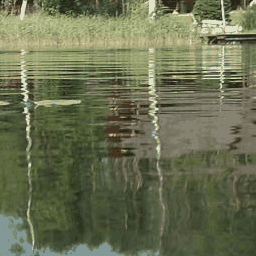

In [81]:
ttt = Image.fromarray(image).quantize(64)
ttt

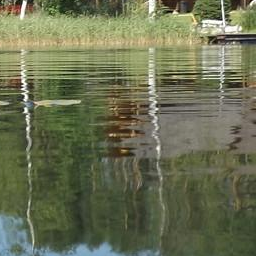

In [82]:
Image.fromarray(image)